In [1]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 5.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 3.2 MB/s eta 0:00:00a 0:00:01


# Configuring the files 

In [2]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import timm 
import os 
from tqdm.notebook import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

In [10]:
class config:
    
    epochs = 5                                                  # No. of epochs of training the model 
    lr = 0.001                                                   # Learning rate 
    batch_size = 16                                              # Batch Size For Dataset 
    
    model_name = 'tf_efficientnet_b4_ns'                          # Model name (We are going to import model from timm)
    img_size = 224
    
    # Going to be use for loading dataset 
    DATA_DIR = "/Users/sahithyaaarulselvam/Downloads/chest_xray"     # Data Directory 
    TEST = 'test'                                                 # Test folder name in data directory 
    TRAIN = 'train'                                               # Train folder name in data directory 
    VAL ='val'                                                    # Valid folder name in data directory 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("On which device we are on : {}".format(device))

On which device we are on : cpu


# Transformation of images and loading datasets

In [11]:
from torchvision import transforms as T, datasets

In [12]:
train_transform = T.Compose([
            
    T.Resize(size = (config.img_size,config.img_size)),
    T.RandomRotation(degrees = (-20,+20)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
    
    T.Resize(size = (config.img_size,config.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    
    T.Resize(size = (config.img_size,config.img_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

The dimensions of the image are 2234 pixels width and 2359 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 124.3910 and the standard deviation is 56.3308


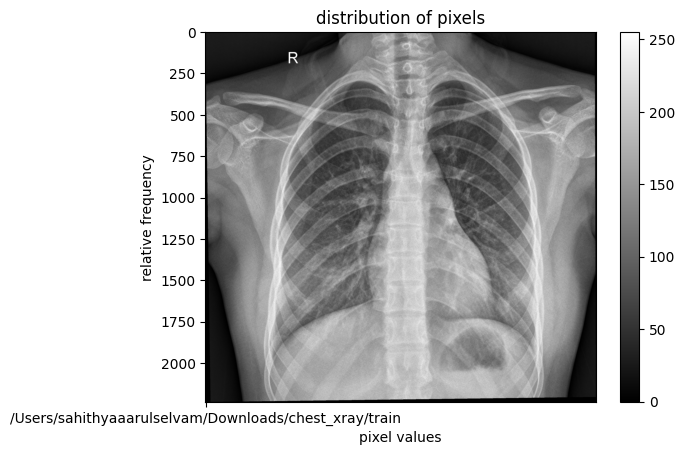

In [13]:
train_path = os.path.join(config.DATA_DIR,config.TRAIN)
train_normal_img = os.listdir("/Users/sahithyaaarulselvam/Downloads/chest_xray/train/NORMAL")[0]
train_dir = "/Users/sahithyaaarulselvam/Downloads/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(train_dir, train_normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")
plt.hist(np.array(train_path).ravel(), bins=100, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

/var/folders/qs/nvh2h6rn6cs45bzpf4z2qd3w0000gn/T/ipykernel_33276/2497118673.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_img.ravel(),


Text(0, 0.5, '# Pixels in Image')

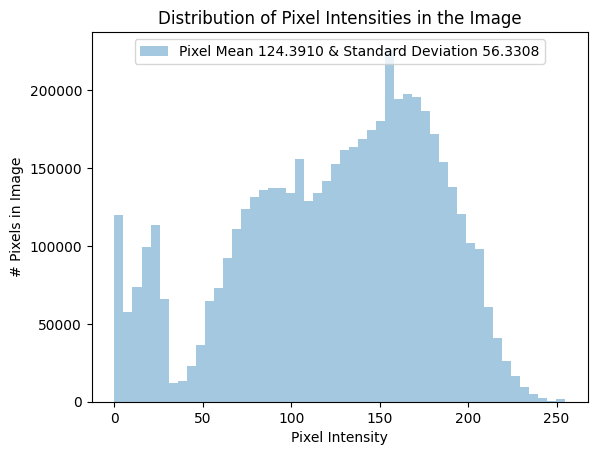

In [14]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [15]:
train_path = os.path.join(config.DATA_DIR, config.TRAIN)
valid_path = os.path.join(config.DATA_DIR, config.VAL)
test_path = os.path.join(config.DATA_DIR, config.TEST)

trainset = datasets.ImageFolder(train_path,transform = train_transform)
validset = datasets.ImageFolder(valid_path,transform = valid_transform)
testset = datasets.ImageFolder(test_path,transform = test_transform)

In [16]:
print("Trainset Size : {}".format(len(trainset)))
print("Validset Size : {}".format(len(validset)))
print("Testset Size : {}".format(len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


In [17]:

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

   

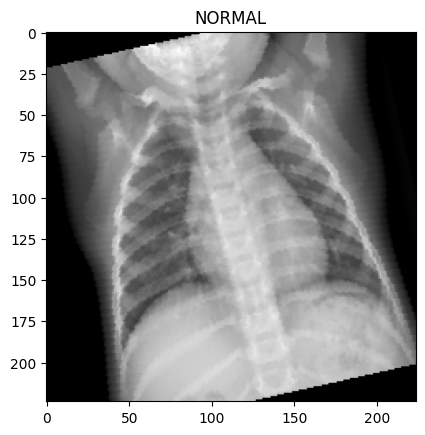

In [18]:
image, label = trainset[2]

class_names = ['NORMAL','PNEUMONIA']

show_image(image,class_names[label])

# Load Datasets into Batches 

In [19]:
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid

In [20]:
trainloader = DataLoader(trainset, batch_size = config.batch_size , shuffle = True)
validloader = DataLoader(validset, batch_size = config.batch_size , shuffle = True)
testloader = DataLoader(testset, batch_size = config.batch_size , shuffle = True)

In [21]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of Total examples : {}".format(len(trainloader.dataset)))

No. of batches in trainloader : 326
No. of Total examples : 5216


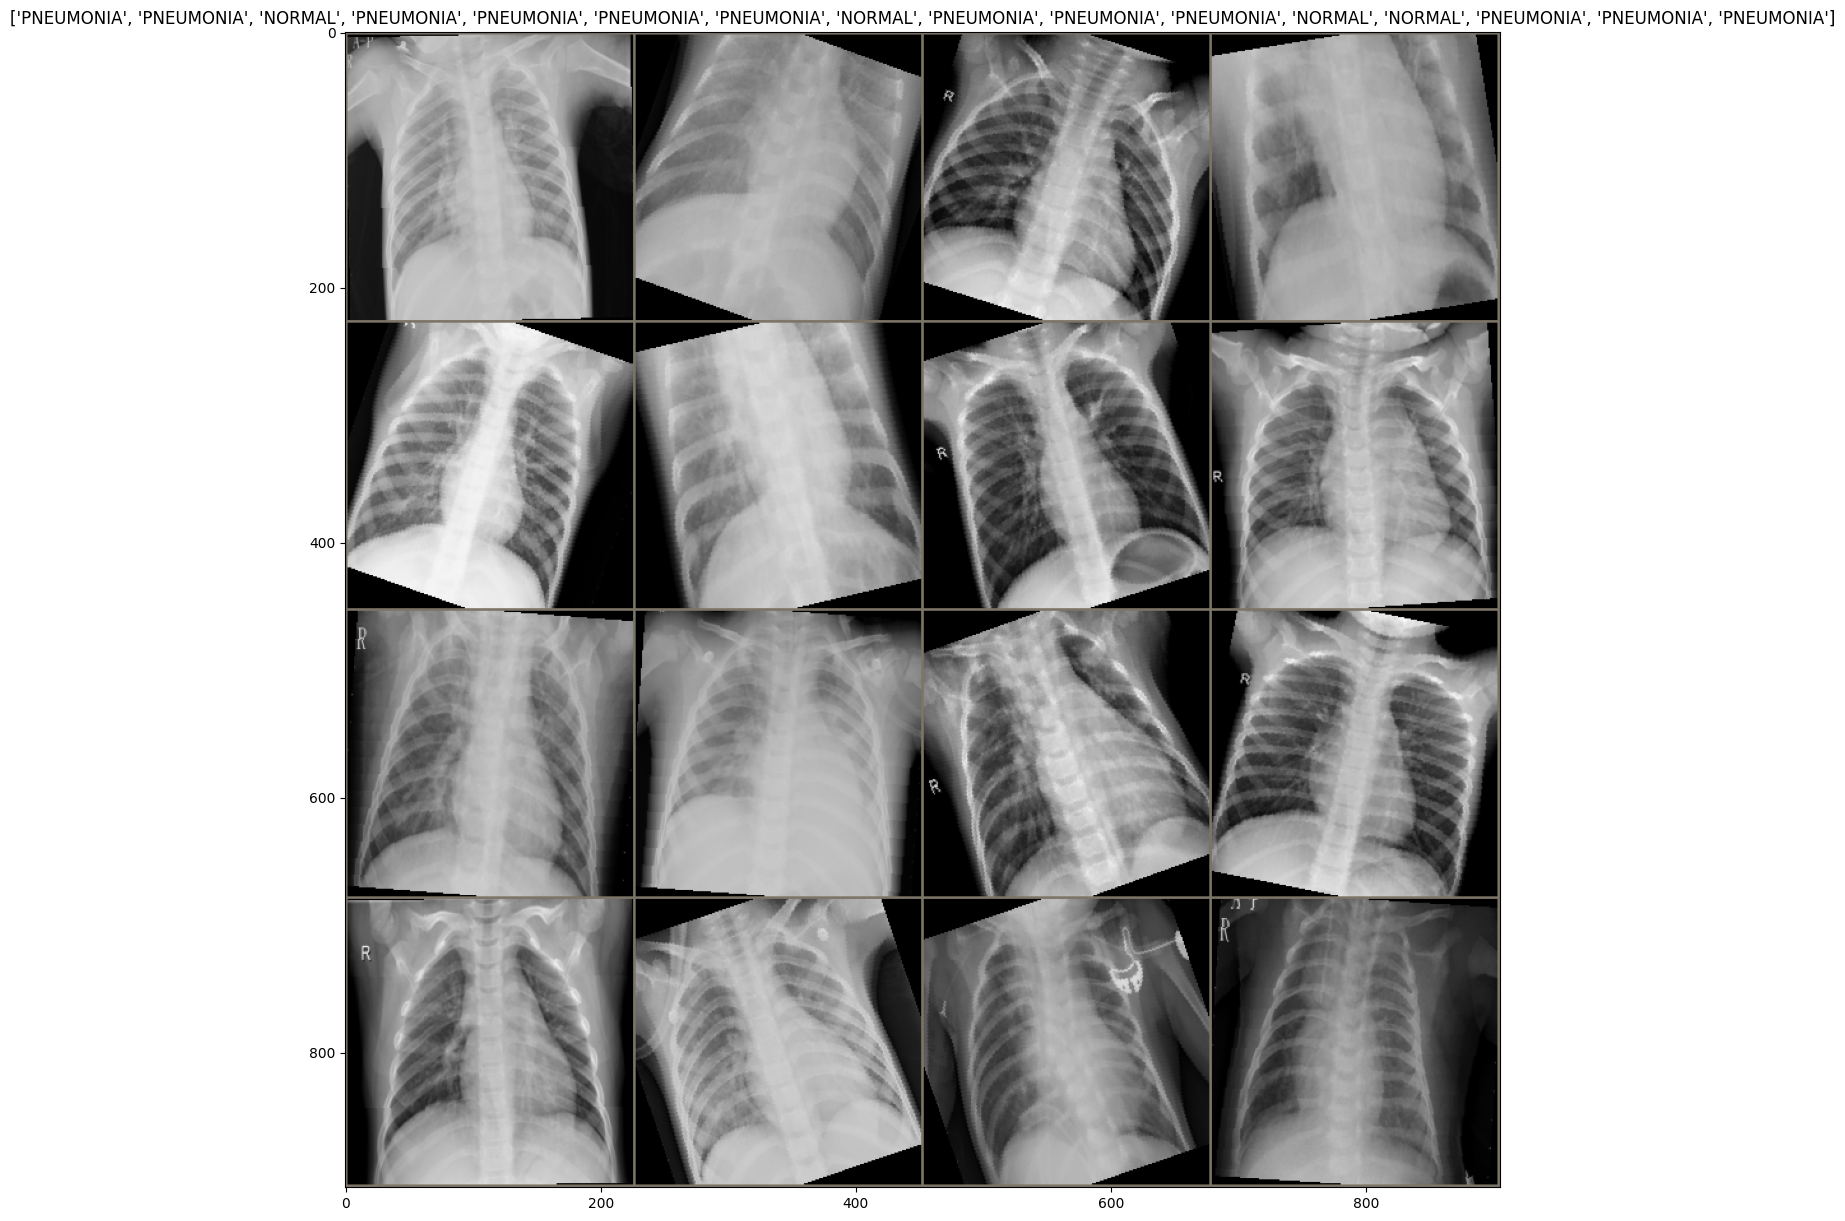

In [22]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

out = make_grid(images,nrow=4)

show_grid(out, title=[class_names[x] for x in labels])



# Fine Tuning of the model 

In [24]:
from torch import nn 
import torch.nn.functional as F

model = timm.create_model(config.model_name,pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(

        nn.Linear(in_features = 1792, out_features = 625),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features = 625, out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features = 256, out_features = 2)

)

model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /Users/sahithyaaarulselvam/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

# Building a training model 

In [26]:
class PneumoniaTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader)
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

# Train the model

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = config.lr)

trainer = PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validloader,epochs = config.epochs)

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.551308810710907
Epoch : 1 Train Loss : 0.254195 Train Acc : 0.899923
Epoch : 1 Valid Loss : 0.551309 Valid Acc : 0.625000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.551308810710907 --> 0.5354278683662415
Epoch : 2 Train Loss : 0.199673 Train Acc : 0.914686
Epoch : 2 Valid Loss : 0.535428 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.5354278683662415 --> 0.45399394631385803
Epoch : 3 Train Loss : 0.189383 Train Acc : 0.925038
Epoch : 3 Valid Loss : 0.453994 Valid Acc : 0.687500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.186768 Train Acc : 0.921204
Epoch : 4 Valid Loss : 0.548494 Valid Acc : 0.625000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.182924 Train Acc : 0.929640
Epoch : 5 Valid Loss : 0.547934 Valid Acc : 0.625000


In [29]:
model.load_state_dict(torch.load('/Users/sahithyaaarulselvam/Downloads/ColabPneumoniaModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss : 0.29145248539936847
Test Acc : 0.875


# Plot Results

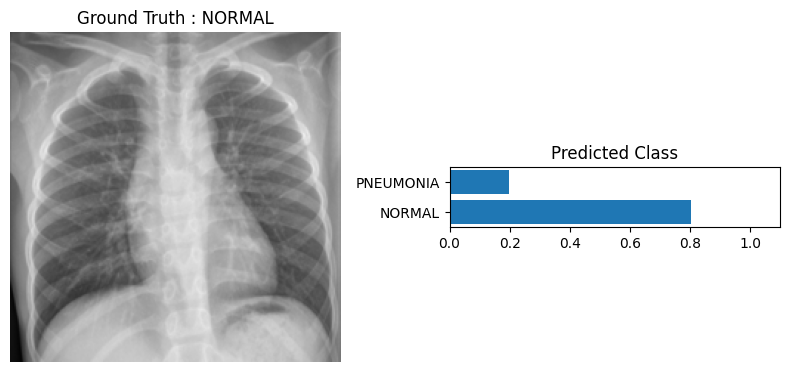

In [31]:
image,label = testset[3]

ps = model(image.unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)